In [231]:
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from functools import partial
from IPython.display import Latex

np.set_printoptions(threshold=5, suppress=True, linewidth=10**3)

## Getting estimations of $\lambda_n, \sigma_n, \mu_n$

In [232]:
mu, sig, lam, dt = 0, 1, 10, 0.1
n_obs, samples, i = 5 * 10**3, 25, 21

In [233]:
u_grid1 = np.linspace(0, 10, n_obs)

In [234]:
Deltas = (np.ones(shape=n_obs + 1) * dt) * np.arange(n_obs + 1)

print(Deltas.shape)
Deltas[:12]

(5001,)


array([0. , 0.1, 0.2, ..., 0.9, 1. , 1.1])

In [235]:
np.random.seed(112)

W_increments = sts.norm.rvs(loc=0, scale=np.sqrt(dt), size=(samples, n_obs))
W_path = np.cumsum(W_increments, axis=1)
W_path = np.insert(W_path, 0, 0, axis=1)

In [236]:
np.random.seed(112)

N_increments = sts.poisson.rvs(mu=lam * dt, size=(samples, n_obs))
N_path = np.cumsum(N_increments, axis=1)
N_path = np.insert(N_path, 0, 0, axis=1)

In [237]:
np.random.seed(112)

chi_seq = sts.norm.rvs(loc=0, scale=1, size=(samples, np.max(N_path[:, -1])))
chi_sum = np.cumsum(chi_seq, axis=1)
chi_sum = np.insert(chi_sum, 0, 0, axis=1)

CPP_path = np.array([np.array([chi_sum[i][n_t] for n_t in N_path[i]]) for i in range(samples)])

In [238]:
M_kDel = np.exp(mu * Deltas + sig * W_path + CPP_path)

In [239]:
D_k = np.log(M_kDel[:, 1:]) - np.log(M_kDel[:, :-1])

print(D_k.shape)
D_k

(25, 5000)


array([[ 1.94503032, -1.73207178,  1.25366896, ..., -0.22059207,  1.1290642 , -1.29070923],
       [ 0.19561552, -0.10529865, -0.13439268, ...,  0.69793418,  0.07111791,  0.21910432],
       [-0.07564179,  0.62771476,  2.10061091, ...,  0.54067304, -2.333226  , -0.28182551],
       ...,
       [-0.02251996,  0.29518462,  0.16776692, ..., -0.05947299, -0.18608798,  0.21153961],
       [-2.15731641, -1.1199574 ,  0.45318768, ..., -0.6079759 ,  0.43479075, -3.00698178],
       [ 1.61465418,  0.0587304 , -0.02642237, ..., -1.10200796, -1.19896454, -1.08417244]])

In [240]:
# Functions
def re_estimation(n_obs, i, dt, D_k, u_grid):
    cos_sq_sum = np.array([arr.sum()**2 for arr in [np.cos(u * D_k[i]) for u in u_grid]])
    sin_sq_sum = np.array([arr.sum()**2 for arr in [np.sin(u * D_k[i]) for u in u_grid]])
    re_hat = -1 / dt * np.log(n_obs) + 1 / (2 * dt) * np.log(cos_sq_sum + sin_sq_sum)
    return re_hat


def im_estimation(i, dt, D_k, u_grid):
    cos_sum = np.array([arr.sum() for arr in [np.cos(u * D_k[i]) for u in u_grid]])
    sin_sum = np.array([arr.sum() for arr in [np.sin(u * D_k[i]) for u in u_grid]])
    im_hat = (1 / dt) * np.arctan(sin_sum / cos_sum)
    return im_hat


def Lam_d(d: int, eps: float, u_til: np.ndarray) -> float:
    w = (eps <= u_til) & (u_til <= 1)
    return (w * u_til**(2 * d)).sum()


def Psi_d(
    n_obs: int, i:int, dt: float, D_k: np.ndarray,
    d: int, eps: float, U_n: float, u_til: np.ndarray 
) -> float:
    
    w = (eps <= u_til) & (u_til <= 1)
    re_hat = re_estimation(n_obs, i, dt, D_k, u_til * U_n)
    return (w * re_hat * (u_til * U_n)**(2 * d)).sum()


def Epsilon(
    i:int, dt: float, D_k: np.ndarray,
    eps: float, V_n: float, u_til: np.ndarray 
):
    
    w = (eps <= u_til) & (u_til <= 1)
    im_hat = im_estimation(i, dt, D_k, u_til * V_n)
    return (w * im_hat * u_til * V_n).sum()

In [241]:
# Initiate
eps, U_n, V_n = 0.5, 6, 6
N = n_obs
div = np.linspace(eps, 1, N - 1)

# Lets compute u_tilda
u_til1 = np.arange(len(div) - 1)
u_til1 = np.vectorize(lambda i: np.random.uniform(div[i], div[i + 1]))(u_til1)
u_til1 = np.insert(u_til1, 0, eps)
u_til1 = np.append(u_til1, 1)

In [242]:
Lam_0 = Lam_d(0, eps, u_til1)
Lam_1 = Lam_d(1, eps, u_til1)
Lam_2 = Lam_d(2, eps, u_til1)

Psi_0 = Psi_d(n_obs, i, dt, D_k, 0, eps, U_n, u_til1)
Psi_1 = Psi_d(n_obs, i, dt, D_k, 1, eps, U_n, u_til1)

Eps = Epsilon(i, dt, D_k, eps, V_n, u_til1)

In [243]:
sig_n = 2 * (Psi_0 * Lam_1 * U_n**2 - Psi_1 * Lam_0) / ((Lam_2 * Lam_0 - Lam_1**2) * U_n**4)
display(Latex(r'$\sigma_n$ = %.2f' % sig_n))

lam_n = (Psi_1 * Lam_1 - Psi_0 * Lam_2 * U_n**2) / ((Lam_2 * Lam_0 - Lam_1**2) * U_n**2)
display(Latex(r'$\lambda_n$ = %.2f' % lam_n))
        
mu_n = Eps / (Lam_1 * V_n**2)
display(Latex(r'$\mu_n$ = %.2f' % mu_n))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Getting an estimation of the density $p$

In [244]:
#Initiate
m = 10**2
x_s = np.linspace(-5, 5, m)

print(x_s.shape)
x_s

(100,)


array([-5.       , -4.8989899, -4.7979798, ...,  4.7979798,  4.8989899,  5.       ])

In [245]:
N = n_obs
T_n = 4
delta = 2 / N

u_grid2 = np.linspace(-1, 1, N - 1)
u_grid2

array([-1.        , -0.99959984, -0.99919968, ...,  0.99919968,  0.99959984,  1.        ])

In [246]:
np.random.seed(112)

u_til2 = np.array([np.random.uniform(u_grid2[i - 1], u_grid2[i]) for i in range(1, len(u_grid2))])
u_til2 = np.insert(u_til2, 0, -1)
u_til2 = np.append(u_til2, 1)

print(u_til2.shape)
u_til2

(5000,)


array([-1.        , -0.99984992, -0.99934362, ...,  0.99923298,  0.99987498,  1.        ])

In [247]:
u_arc = T_n * u_til2

print(u_arc.shape)
u_arc

(5000,)


array([-4.        , -3.99939967, -3.99737446, ...,  3.99693194,  3.99949993,  4.        ])

In [248]:
def kernel(x):
    if abs(x) <= 0.05:
        return 1
    elif 0.05 < abs(x) and abs(x) < 1:
        return np.exp(-np.exp(-1 / (abs(x) - 0.05)) / (1 - abs(x)))
    return 0


def phi_estimation(
    i: int, n_obs: int, dt: float, u_arc: np.ndarray, D_k: np.ndarray
):
    
    return np.array([(1 / dt) * np.log((1 / n_obs) * np.sum(np.exp(1j * u * D_k[i]))) for u in u_arc])


def density_estimation(
    i: int, n_obs: int, dt: float, T_n: float, delta: float, lam_n: float, sig_n: float, mu_n: float,
    u_arc: np.ndarray, x_s: float
):
    
    phi_est = phi_estimation(i, n_obs, dt, u_arc, D_k)
    
    
    
    #phi_est = re_estimation(n_obs, i, dt, D_k, u_arc) + 1j * im_estimation(i, dt, D_k, u_arc)
    
    
    kern = np.array([kernel(u / T_n) for u in u_arc])
    # kern = 1
    
    return ((T_n * delta) / (2 * np.pi * lam_n)) * np.sum(
        np.exp(-1j * u_arc * x_s) * (phi_est - 1j * mu_n * u_arc + (1 / 2) * sig_n**2 * u_arc**2 + lam_n) * kern
    )

In [249]:
p_estimated = np.array([density_estimation(i, n_obs, dt, T_n, delta, lam_n, sig_n, mu_n, u_arc, x) for x in tqdm(x_s)])

print(p_estimated.shape)
p_estimated

100%|█████████████████████████████████████████| 100/100 [00:53<00:00,  1.85it/s]

(100,)


array([-0.0017137 +0.00000923j, -0.00140362+0.00000865j, -0.00094677+0.00000809j, ..., -0.00240695-0.00000754j, -0.00223509-0.00000823j, -0.00187036-0.00000898j])

In [250]:
p_real = (1 / np.sqrt(2 * np.pi)) * np.exp(-x_s**2 / 2)

In [251]:
MSE = (1 / m) * np.sum((p_estimated - p_real)**2)
MSE

(0.00041837563592940594+7.046380685131915e-09j)

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


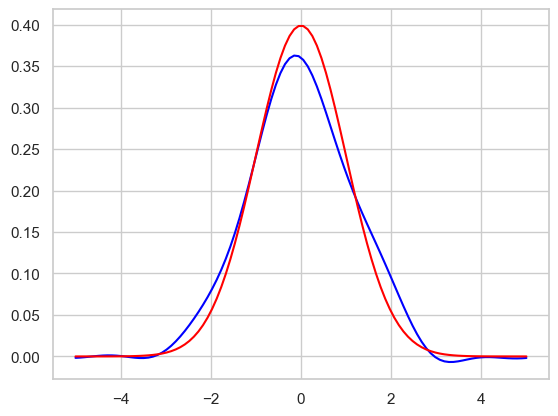

In [252]:
sns.set(style="whitegrid")

sns.lineplot(x=x_s, y=p_estimated, color='blue')
sns.lineplot(x=x_s, y=p_real, color='red')

plt.show()

In [208]:
from scipy.integrate import quad

# Define the function to be integrated
def f(x):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2)

# Compute the definite integral of f from 0 to 1
result, error = quad(f, -1000, 1000)
print("Result:", result)
print("Estimated error:", error)

Result: 1.0
Estimated error: 1.820990033533866e-12
